# KNN
[Step 1] 데이터 준비/ 기본 설정

In [1]:
### 기본 라이브러리 불러오기
import pandas as pd
import seaborn as sns

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

In [2]:
# 데이터 살펴보기
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


[Step 2] 데이터 탐색

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


- 0: survived: 생존 여부 => 0 = No, 1 = Yes
- 1: pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
- 2: sex: 성별
- 3: age: 나이
- 4: sibsp: 함께 탑승한 형제자매, 배우자의 수
- 5: parch: 함께 탑승한 부모, 자식의 수
- 6: fare: 운임
- 7: embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton
- 8: class: 객실 등급
- 9: who: 남자/여자/아이
- 10: adult_male: 성인 남성
- 11: deck: 객실 데크 위치
- 12: embark_town: 승선 도시
- 13: alive: 생존 여부
- 14: alone: 동행자 여부

In [4]:
# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  
rdf.columns.values

array(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'alive', 'alone'],
      dtype=object)

In [5]:
# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    712 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [ ]:
rdf['embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [9]:
rdf['embarked'].value_counts()

S    554
C    130
Q     28
Name: embarked, dtype: int64

In [ ]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
most_freq

'S'

In [ ]:
rdf['embarked'].fillna(most_freq, inplace=True)

In [ ]:
df.describe(include='all')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,203,889,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,491,537,537,59,644,549,537
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Step 3] 분석에 사용할 속성을 선택

In [10]:
# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 
           'age', 'sibsp', 'parch', 'embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [11]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   sex       714 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     714 non-null    int64  
 5   parch     714 non-null    int64  
 6   embarked  712 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ KB


In [12]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
onehot_sex.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [13]:
ndf = pd.concat([ndf, onehot_sex], axis=1)
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked,female,male
0,0,3,male,22.0,1,0,S,0,1
1,1,1,female,38.0,1,0,C,1,0
2,1,3,female,26.0,0,0,S,1,0
3,1,1,female,35.0,1,0,S,1,0
4,0,3,male,35.0,0,0,S,0,1


In [14]:
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
onehot_embarked.head()

,town_C,town_Q,town_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [15]:
ndf = pd.concat([ndf, onehot_embarked], axis=1)
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked,female,male,town_C,town_Q,town_S
0,0,3,male,22.0,1,0,S,0,1,0,0,1
1,1,1,female,38.0,1,0,C,1,0,1,0,0
2,1,3,female,26.0,0,0,S,1,0,0,0,1
3,1,1,female,35.0,1,0,S,1,0,0,0,1
4,0,3,male,35.0,0,0,S,0,1,0,0,1


In [16]:
ndf.drop(['sex', 'embarked'], axis=1, inplace=True)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


[Step 4] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [17]:
# 속성(변수) 선택
X=ndf[list(ndf.columns)[1:]]  #독립 변수 X
y=ndf[list(ndf.columns)[0]]  

In [18]:
X.shape

(714, 9)

In [19]:
y.shape

(714,)

In [25]:
# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [26]:
# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=10) 


In [ ]:
print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


[Step 5] KNN 분류 모형 - sklearn 사용

In [ ]:
X_train # 스케일링된 X의 값 사람이보기 편하게 바꾼것이 아닌 컴퓨터가 보라고 만듦.

array([[-1.47636364,  2.3629184 ,  0.52457013, ..., -0.47180795,
        -0.20203051,  0.53307848],
       [ 0.91123237, -0.46148866, -0.55170307, ..., -0.47180795,
        -0.20203051,  0.53307848],
       [ 0.91123237, -0.73704057, -0.55170307, ..., -0.47180795,
        -0.20203051,  0.53307848],
       ...,
       [-0.28256564, -0.32371271, -0.55170307, ..., -0.47180795,
        -0.20203051,  0.53307848],
       [-1.47636364,  1.4673747 , -0.55170307, ...,  2.11950647,
        -0.20203051, -1.87589641],
       [-1.47636364, -0.9437045 , -0.55170307, ...,  2.11950647,
        -0.20203051, -1.87589641]])

In [27]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5로 설정)
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn.predict(X_test)

In [29]:
import pandas as pd
df = pd.DataFrame({'y_hat':y_hat,'y':y_test})

In [30]:
df.head()

,y_hat,y
728,0,0
555,0,0
426,1,1
278,0,0
617,0,0


In [ ]:
df['차이'] = df['y_hat'] == df['y']
df.head()

,y_hat,y,차이
728,0,0,True
555,0,0,True
426,1,1,True
278,0,0,True
617,0,0,True


In [ ]:
len(df)

215

In [ ]:
print('오답 수:',len(df) - sum(df['차이']))

오답 수: 41


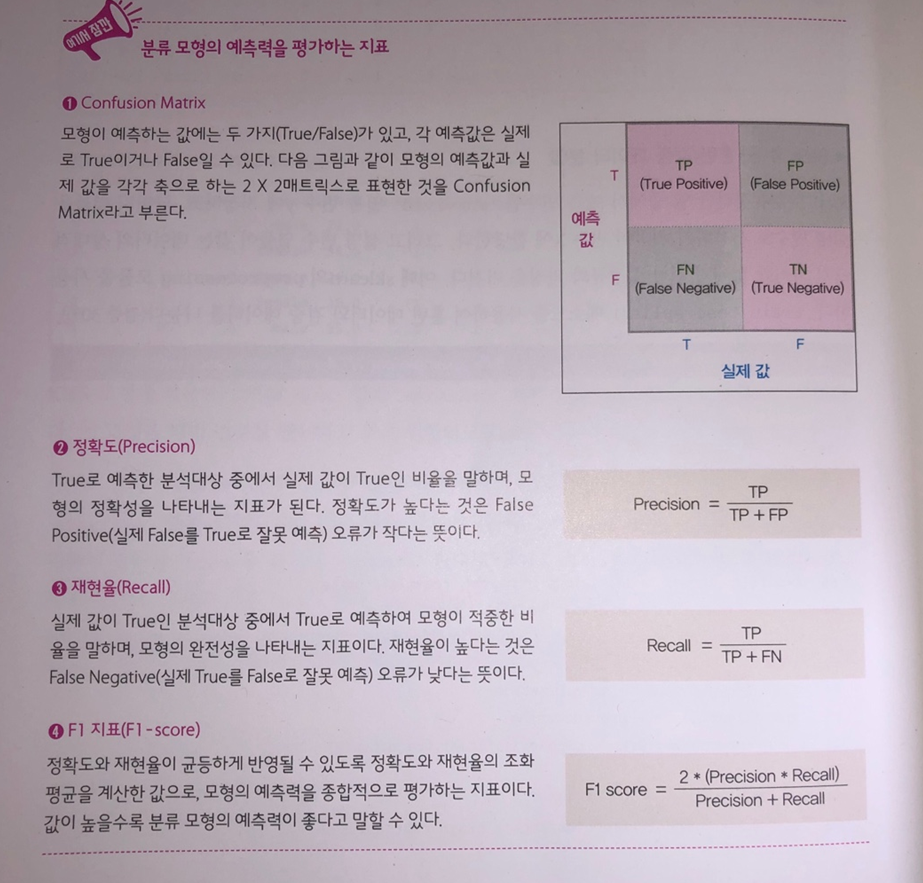

In [ ]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
knn_matrix = metrics.confusion_matrix(y_test, y_hat)  
knn_matrix

array([[109,  16],
       [ 25,  65]])

In [ ]:
# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test, y_hat)     
print(knn_report)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       125
           1       0.80      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215

